In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
from pickle import load
from math import ceil
from numpy.random import choice
from keras import Model
from keras.applications import ResNet152V2
from keras.layers import Input, Dense, LSTM, Embedding, Add, Dropout
from keras import layers
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy
from keras.callbacks import EarlyStopping, TensorBoard

from functions.text_processing import create_vocab_mappings
from functions.training import data_generator
from keras.utils import plot_model

from keras_tuner import HyperModel, HyperParameters, BayesianOptimization

from functions.text_processing import create_vocab_mappings
from functions.image_processing import load_image, display_image
from functions.training import data_generator
from functions.model_evaluation import generate_and_evaluate_caption


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\james\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
SEQ_LENGTH = 20
EMBED_DIM = 300
FF_DIM = 512
HIDDEN_DIM = 512
EPOCHS = 100
DROPOUT = 0.4
BATCH_SIZE = 512
EVAL_BATCH_SIZE = 1024


In [4]:
with open('preprocessed_data/vocab.pkl', 'rb') as file:
    vocab = load(file)
    
VOCAB_SIZE = len(vocab)
    
with open('preprocessed_data/embedding_matrix.pkl', 'rb') as file:
    embedding_matrix = load(file)
    
EMBED_DIM = embedding_matrix.shape[1]

word_to_idx, idx_to_word = create_vocab_mappings(vocab)

In [5]:
DIR = 'preprocessed_data/coco/'

with open(DIR + 'train_caption_map.pkl', 'rb') as file:
    train_caption_map = load(file)
    
with open(DIR + 'train_avg_feature_map.pkl', 'rb') as file:
    train_feature_map = load(file)
    
train_images = list(train_caption_map.keys())
STEPS = ceil(len(train_images) * 5 / BATCH_SIZE)
    
train_data = data_generator (train_images, train_caption_map, train_feature_map, BATCH_SIZE)

with open(DIR + 'val_caption_map.pkl', 'rb') as file:
    val_caption_map = load(file)
    
with open(DIR + 'val_avg_feature_map.pkl', 'rb') as file:
    val_feature_map = load(file)
    
val_images = list(val_caption_map.keys())
VAL_STEPS = ceil(len(val_images) * 5 / BATCH_SIZE)
val_data = data_generator(val_images, val_caption_map, val_feature_map, BATCH_SIZE)


In [6]:
'''
The layers: 
- TransformerEncoderBlock
- PositionalEmbedding
- TransformerDecoderBlock 

Are from the Keras image captioning example
- Author: A_K_Nain
- Source: https://keras.io/examples/vision/image_captioning/#building-the-model
'''

class TransformerEncoderBlock(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, dropout_rate, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embed_dim,
            dropout=dropout_rate
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.dense_1 = layers.Dense(embed_dim, activation="relu")

    def call(self, inputs, training, mask=None):
        inputs = self.layernorm_1(inputs)
        inputs = self.dense_1(inputs)
        
        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=None,
            training=training,
        )
        out_1 = self.layernorm_2(inputs + attention_output_1)
        return out_1


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, embedding_matrix, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = Embedding(
            input_dim=vocab_size, 
            output_dim=embed_dim,
            input_length=sequence_length,
            trainable=False,
            weights=[embedding_matrix], 
        )
        self.position_embeddings = Embedding(
            input_dim=sequence_length,
            output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.embed_scale = tf.math.sqrt(tf.cast(embed_dim, tf.float32))

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_tokens = embedded_tokens * self.embed_scale
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)


class TransformerDecoderBlock(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, embedding_matrix, ff_dim, num_heads, dropout_rate, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.ffn_layer_1 = layers.Dense(ff_dim, activation="relu")
        self.ffn_layer_2 = layers.Dense(embed_dim)

        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        
        self.embedding = PositionalEmbedding(
            embed_dim=embed_dim,
            sequence_length=sequence_length,
            vocab_size=vocab_size,
            embedding_matrix=embedding_matrix
        )
        self.out = layers.Dense(vocab_size, activation="softmax")

        self.dropout_1 = layers.Dropout(dropout_rate)
        self.dropout_2 = layers.Dropout(dropout_rate)
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, training, mask=None):
        inputs = self.embedding(inputs)
        causal_mask = self.get_causal_attention_mask(inputs)

        if mask is not None:
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
            combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            combined_mask = tf.minimum(combined_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=combined_mask,
            training=training,
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
            training=training,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        ffn_out = self.ffn_layer_1(out_2)
        ffn_out = self.dropout_1(ffn_out, training=training)
        ffn_out = self.ffn_layer_2(ffn_out)

        ffn_out = self.layernorm_3(ffn_out + out_2, training=training)
        ffn_out = self.dropout_2(ffn_out, training=training)
        preds = self.out(ffn_out)
        return preds

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [
                tf.expand_dims(batch_size, -1),
                tf.constant([1, 1], dtype=tf.int32),
            ],
            axis=0,
        )
        return tf.tile(mask, mult)

In [7]:
class ImageCaptioningHypermodel(HyperModel):
    def __init__(self, feature_size, sequence_len, vocab_size, embedding_matrix, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.feature_size = feature_size
        self.sequence_len = sequence_len
        self.vocab_size = vocab_size
        self.embedding_matrix = embedding_matrix
        
    def build(self, hp):
        dense_dim = hp.Choice('dense_dim', values = [256, 512, 1024])
        encoder_heads = hp.Int('encoder_heads', min_value = 2, max_value = 8, step = 2)
        decoder_heads = hp.Int('decoder_heads', min_value = 2, max_value = 8, step = 2)
        encoder_dropout = hp.Float('encoder_dropout', min_value=0.1, max_value=0.5, step=0.1)
        decoder_dropout = hp.Float('decoder_dropout', min_value=0.1, max_value=0.5, step=0.1)
        learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4])
             
        encoder = TransformerEncoderBlock(
            embed_dim=EMBED_DIM,
            dense_dim=dense_dim,
            num_heads=encoder_heads, 
            dropout_rate=encoder_dropout
        )
        decoder = TransformerDecoderBlock(
            sequence_length=SEQ_LENGTH,
            vocab_size=VOCAB_SIZE,
            embed_dim=EMBED_DIM,
            embedding_matrix=self.embedding_matrix,
            ff_dim=dense_dim,
            num_heads=decoder_heads, 
            dropout_rate=decoder_dropout
        )
        
        image_features = Input(shape=(self.feature_size,))
        reshaped_image_features = layers.Reshape((1, -1))(image_features)
        caption_input = Input(shape=(self.sequence_len,))
        encoder_output = encoder(reshaped_image_features, training=True, mask=None)
        mask = tf.math.not_equal(caption_input, 0) 
        decoder_output = decoder(caption_input, encoder_output, training=True, mask=mask)
        
        model =  Model(inputs=[image_features, caption_input], outputs= decoder_output)
        model.compile(loss=SparseCategoricalCrossentropy(), optimizer=Adam(learning_rate), metrics=['accuracy'])
        return model

In [9]:
feature_size = 1280
hypermodel = ImageCaptioningHypermodel(feature_size, SEQ_LENGTH, VOCAB_SIZE, embedding_matrix)

tuner = BayesianOptimization(
    hypermodel,
    objective='val_loss',
    max_trials=200,
    directory='keras_tuning',
    project_name='cnn_transformer_tuning',
)

callbacks = [
    TensorBoard(
        log_dir='./tensorboard_logs/cnn_transformer_tuning/',
        histogram_freq=1,
        write_graph=True,
        update_freq='epoch'
    ),
]

In [ ]:
tuner.search(
    train_data,
    epochs = 3,
    steps_per_epoch=STEPS,
    validation_data=val_data,
    validation_steps=VAL_STEPS,
    callbacks= callbacks,
    verbose=1
)

In [11]:
tuner.results_summary(5)

Results summary
Results in keras_tuning\cnn_transformer_tuning
Showing 5 best trials
Objective(name="val_loss", direction="min")

Trial 148 summary
Hyperparameters:
dense_dim: 1024
encoder_heads: 2
decoder_heads: 8
encoder_dropout: 0.5
decoder_dropout: 0.1
learning_rate: 0.001
Score: 1.4806910753250122

Trial 050 summary
Hyperparameters:
dense_dim: 1024
encoder_heads: 2
decoder_heads: 8
encoder_dropout: 0.1
decoder_dropout: 0.1
learning_rate: 0.001
Score: 1.4832299947738647

Trial 172 summary
Hyperparameters:
dense_dim: 1024
encoder_heads: 2
decoder_heads: 8
encoder_dropout: 0.1
decoder_dropout: 0.1
learning_rate: 0.001
Score: 1.483860731124878

Trial 187 summary
Hyperparameters:
dense_dim: 1024
encoder_heads: 2
decoder_heads: 8
encoder_dropout: 0.5
decoder_dropout: 0.1
learning_rate: 0.001
Score: 1.483906865119934

Trial 195 summary
Hyperparameters:
dense_dim: 1024
encoder_heads: 2
decoder_heads: 8
encoder_dropout: 0.1
decoder_dropout: 0.1
learning_rate: 0.001
Score: 1.483973026275634

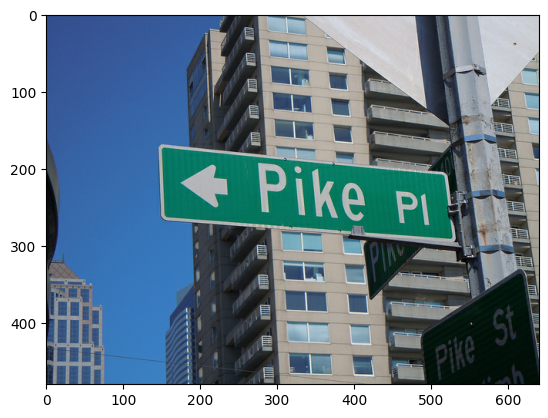

Predicted caption:
a street sign on a pole with a street sign on it

True captions: 
a close up image of a street sign letting people know where they are
a pole with some street signs next to a high rise
a green street sign that reads [UNK] hanging from a pole
a street sign with the words [UNK] plaza on it
there is a street sign that shows an arrow and a street name

BLEU score:  [0.75, 0.6396021490668313, 0.43412681107162016, 0.21801147251649955]
METEOR score:  0.5514705882352942


Predicted caption:
a street sign on a pole on top of a pole

True captions: 
a close up image of a street sign letting people know where they are
a pole with some street signs next to a high rise
a green street sign that reads [UNK] hanging from a pole
a street sign with the words [UNK] plaza on it
there is a street sign that shows an arrow and a street name

BLEU score:  [0.6363636363636364, 0.504524979109513, 0.304677894412465, 0.17063407610369333]
METEOR score:  0.4054545454545455


Predicted caption:
a 

In [10]:
test_image = choice(val_images)
test_features = val_feature_map[test_image]
true_captions = val_caption_map[test_image]

# Testing the top three models 

display_image('datasets/coco/val2014/', test_image)

best_models = tuner.get_best_models(3)

for model in best_models: 
    generate_and_evaluate_caption(test_features, idx_to_word, model, SEQ_LENGTH, true_captions) 
    print('\n')

In [39]:
best_hp = tuner.get_best_hyperparameters(3)[2]

model = hypermodel.build(best_hp)

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

training = model.fit(
    train_data,
    epochs = 100,
    steps_per_epoch=STEPS,
    validation_data=val_data,
    validation_steps=VAL_STEPS,
    callbacks= [early_stopping],
    verbose=1
)

Epoch 1/100
809/809 [==============================] - 61s 73ms/step - loss: 1.7682 - accuracy: 0.4413 - val_loss: 1.5788 - val_accuracy: 0.4714
Epoch 2/100
809/809 [==============================] - 59s 73ms/step - loss: 1.5148 - accuracy: 0.4830 - val_loss: 1.5216 - val_accuracy: 0.4841
Epoch 3/100
809/809 [==============================] - 59s 72ms/step - loss: 1.4546 - accuracy: 0.4945 - val_loss: 1.4894 - val_accuracy: 0.4901
Epoch 4/100
809/809 [==============================] - 59s 73ms/step - loss: 1.4222 - accuracy: 0.5008 - val_loss: 1.4726 - val_accuracy: 0.4943
Epoch 5/100
809/809 [==============================] - 59s 73ms/step - loss: 1.3991 - accuracy: 0.5051 - val_loss: 1.4680 - val_accuracy: 0.4956
Epoch 6/100
809/809 [==============================] - 59s 73ms/step - loss: 1.3795 - accuracy: 0.5089 - val_loss: 1.4581 - val_accuracy: 0.4979
Epoch 7/100
809/809 [==============================] - 58s 72ms/step - loss: 1.3670 - accuracy: 0.5111 - val_loss: 1.4584 - val_ac

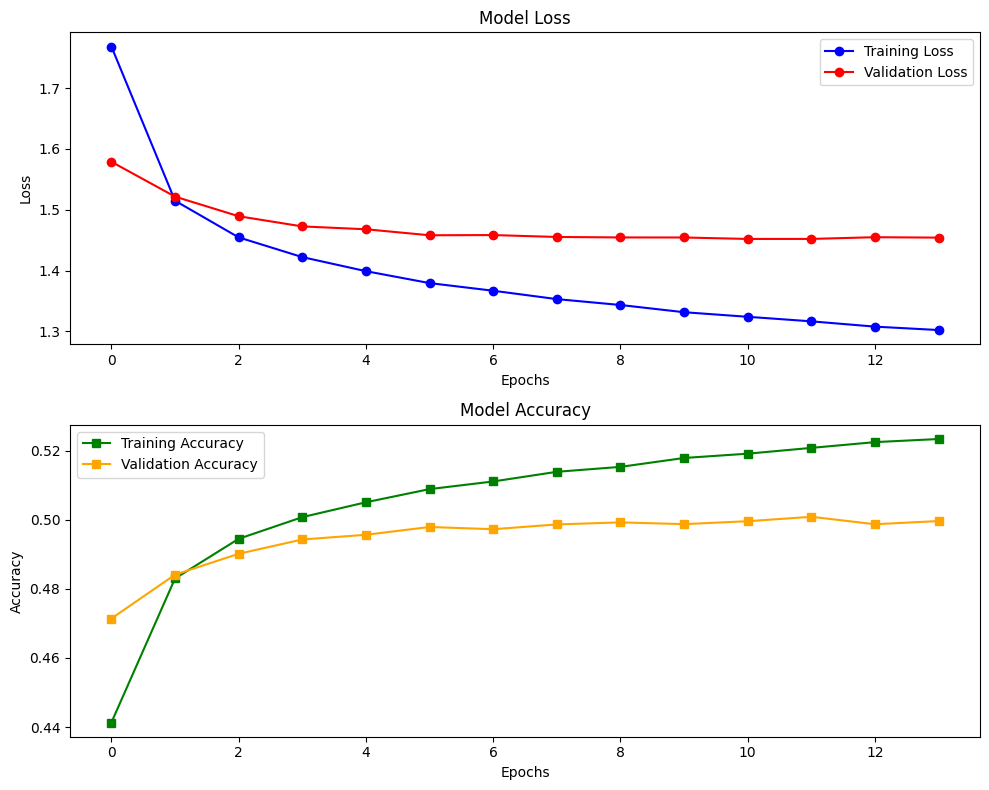

In [40]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# Plotting Loss
axes[0].plot(training.history['loss'], marker='o', color='b', label='Training Loss')
axes[0].plot(training.history['val_loss'], marker='o', color='r', label='Validation Loss')
axes[0].set_title('Model Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Plotting Accuracy
axes[1].plot(training.history['accuracy'], marker='s', color='g', label='Training Accuracy')
axes[1].plot(training.history['val_accuracy'], marker='s', color='orange', label='Validation Accuracy')
axes[1].set_title('Model Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()

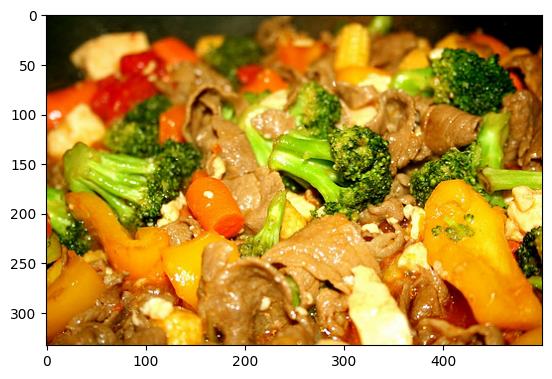

Predicted caption:
a plate of pasta with broccoli and broccoli

True captions: 
a pile of stir fried meat and vegetables covered in a sauce
a plate full of beef with broccoli and carrots
the meal consists of beef brocolli and other vegetables
close up of food that includes beef carrots and broccoli
a [UNK] salad with broccoli and peppers up close

BLEU score:  [0.6618726769384466, 0.5777298366654254, 0.36615967268911115, 0.20602757874730404]
METEOR score:  0.47908863920099876


In [51]:
test_image = choice(val_images)
test_features = val_feature_map[test_image]
true_captions = val_caption_map[test_image]

display_image('datasets/coco/val2014/', test_image)

generate_and_evaluate_caption(test_features, idx_to_word, model, SEQ_LENGTH, true_captions) 

In [42]:
from functions.model_evaluation import batch_generate_captions, evaluate_captions

predicted_captions, true_captions = batch_generate_captions(val_images, val_feature_map, val_caption_map, idx_to_word, model, SEQ_LENGTH, 1024)
evaluate_captions(predicted_captions, true_captions)

32/32 [==============================] - 0s 5ms/step


([0.6680542022615247,
  0.47848925024330374,
  0.32883372970872016,
  0.22983470533342176],
 0.4337622519793736)

- ([0.6566525747696405,
  0.46475125022830116,
  0.311301620339562,
  0.21286200107485656],
 0.41116280406869266) first iteration 5 epochs 
 - ([0.6641633469587254,
  0.4708016193944267,
  0.31741534441381347,
  0.21806740313687273],
 0.4172896946730811) 13 epochs
 - ([0.6769419012284784,
  0.48705122642136006,
  0.33520539875414057,
  0.2339796332527282],
 0.4359143213235547) tuning best hypermodel